I am following the 3rd Global Edition of **Computer Systems: A Programmer's Perspective** by Bryant and O'Hallaron. IEEE floats are covered in Section 2.4.2

IEEE-754 floating-point standard represents a number in a form $V = (-1)^s \times M \times 2^E$

- sign $s$: 1 is negative, 0 is positive
- significand $M$ is a fractional binary number that ranges between 1 and 2-eps (for normalized floats) or between 0 and 1-eps (for denormalized floats)
- exponent $E$ weights the value by a (possibly negative) power of 2

In particular:
- fp32 has 1 sign bit, 8 exponent bits (uint with bias of 127), 23 fraction bits
- fp64 has 1 sign bit, 11 exponent bits (uint with bias of 1023), 52 fraction bits

Depending on exponent bits the value represented falls into three cases:
- **Normalized values** when exp is not all zero or all one. The exponent value is the uint in the exp field, shifted by a bias. The fractional value 0 <= f < 1 is encoded in the frac bits. The significand M is then M = 1 + f ("implied leading 1 representation"). This representation is a trick for getting an additional bit of precision for free, since (just as is the case in scientific notation) we can always adjust the exponent E so that the significant M is in the range 1 <= M < 2 (assuming there is no overflow). We therefore do not need to explicitly represent the leading bit, since it will always equal 1.
- **Denormalized values** when exp is all zeros, then exponent is "clamped" to E = 1 - bias (instead of simply -bias, as it would be if we followed the rules for normalized values), but then the significand M not does not assume the leading bit, so 0 <= M < 1. Since M == 0 is now a possibility we can also represent exact zero.
- **Spcial cases** when exp field is all ones. When fraction field is all zeros we get pos/neg infinity depending on sign bit. Otherwise we get nan. (Hey that's a lot of wasted representation space to collapse into nan! :))

In [1]:
class UInt:
    
    @classmethod
    def val(self, bits: str):
        u = sum(int(d) * 2**i for i,d in enumerate(bits[::-1]))
        return u

class Frac:
    
    @classmethod
    def val(self, bits: str):
        u = sum(int(d) * 2**(-i-1) for i,d in enumerate(bits))
        return u

In [2]:
from fractions import Fraction

class Float:
    
    @classmethod
    def val(self, bits: str, verbose=True):
        
        # the bits are string, with a space between the sign bit, exponent and fraction
        sign_bits, exp_bits, frac_bits = bits.split(' ')
        assert len(sign_bits) == 1
        assert len(exp_bits)  >= 1
        assert len(frac_bits) >= 1
        k = len(exp_bits)
        n = len(frac_bits)
        bias = 2**(k - 1) - 1
        
        # decode the raw binary representations of the exponent and the fraction
        sign = int(sign_bits)
        e = UInt.val(exp_bits)
        f = Frac.val(frac_bits)
        # now interpret the "implied" exponent / fraction and handle special cases
        if e == 2**k - 1:
            # all of exponent bits are 1: special-cased infinity, nan, etc.
            if f == 0:
                # when fraction is all zeros we get infinity
                if verbose:
                    print(f"{bits=} {'+' if sign == 0 else '-'}Infinity")
                return float('inf') if sign == 0 else float('-inf')
            else:
                # otherwise we get nan
                if verbose:
                    print(f"{bits=} NaN")
                return float('nan')
        elif e > 0:
            # a typical normalized float
            E = e - bias
            M = 1 + f
        elif e == 0:
            # all of exponent bits are 0: denormalized float
            E = 1 - bias # we basically "cap" e at min of 1, to create an equal-spaced gradual underflow of IEEE754 float
            M = f # there is no leading 1. (allowing us to also create an actual zero)
        else:
            raise ValueError("??? should never make it here")
        
        # construct the (Python) float manually
        V = (-1)**sign * M * 2**E
        
        # debugging and such
        twoPowE = str(2**E) if E >= 0 else "1/" + str(2**-E)
        fNum = sum(int(d) * 2**(n-i-1) for i,d in enumerate(frac_bits))
        fDen = 2**n
        fStr = f'{fNum}/{fDen}'
        Mnum = fNum + (0 if e == 0 else fDen) # the 2nd expression implements the "1 + " part in construction of M from f
        Mden = fDen
        MStr = f'{Mnum}/{Mden}'
        if verbose:
            Vfrac = str(Fraction.from_float(V))
            print(f"{bits=} {e=:2}, {E=:3}, 2^E={twoPowE:5}, f={fStr:5}, M={MStr:5}, V={Vfrac:8} Decimal={V}")
        return V


In [3]:
# Reproduce Figure 2.35 (Page 145). Floats with k=4 exponent bits, n=3 fraction bits

# Denormalized float values
Float.val("0 0000 000") # zero
Float.val("0 0000 001") # smallest positive
Float.val("0 0000 010")
Float.val("0 0000 011")
print('...')
Float.val("0 0000 111") # largest denormalized
# Normalized float values
Float.val("0 0001 000") # smallest normalized
Float.val("0 0001 001")
print('...')
Float.val("0 0110 110")
Float.val("0 0110 111")
Float.val("0 0111 000") # one
Float.val("0 0111 001")
Float.val("0 0111 010")
print('...')
Float.val("0 1110 110")
Float.val("0 1110 111") # largest normalized
# Special values
Float.val("0 1111 000") # infinity
Float.val("1 1111 000") # infinity
Float.val("1 1111 111"); # infinity

bits='0 0000 000' e= 0, E= -6, 2^E=1/64 , f=0/8  , M=0/8  , V=0        Decimal=0.0
bits='0 0000 001' e= 0, E= -6, 2^E=1/64 , f=1/8  , M=1/8  , V=1/512    Decimal=0.001953125
bits='0 0000 010' e= 0, E= -6, 2^E=1/64 , f=2/8  , M=2/8  , V=1/256    Decimal=0.00390625
bits='0 0000 011' e= 0, E= -6, 2^E=1/64 , f=3/8  , M=3/8  , V=3/512    Decimal=0.005859375
...
bits='0 0000 111' e= 0, E= -6, 2^E=1/64 , f=7/8  , M=7/8  , V=7/512    Decimal=0.013671875
bits='0 0001 000' e= 1, E= -6, 2^E=1/64 , f=0/8  , M=8/8  , V=1/64     Decimal=0.015625
bits='0 0001 001' e= 1, E= -6, 2^E=1/64 , f=1/8  , M=9/8  , V=9/512    Decimal=0.017578125
...
bits='0 0110 110' e= 6, E= -1, 2^E=1/2  , f=6/8  , M=14/8 , V=7/8      Decimal=0.875
bits='0 0110 111' e= 6, E= -1, 2^E=1/2  , f=7/8  , M=15/8 , V=15/16    Decimal=0.9375
bits='0 0111 000' e= 7, E=  0, 2^E=1    , f=0/8  , M=8/8  , V=1        Decimal=1.0
bits='0 0111 001' e= 7, E=  0, 2^E=1    , f=1/8  , M=9/8  , V=9/8      Decimal=1.125
bits='0 0111 010' e= 7, E=  

In [4]:
# we need a bit of tooling for creating inputs to Float

from functools import partial

def gen_bits(n):
    # generate all bit strings of length n in increasing order
    for i in range(2**n):
        b = str(bin(i))[2:]
        b = '0' * (n - len(b)) + b
        yield b

def chunk_str3(s, parts):
    assert sum(parts) == len(s)
    return s[:parts[0]] + ' ' + s[parts[0]:parts[0]+parts[1]] + ' ' + s[parts[0]+parts[1]:]


In [5]:
# Reproduce Figure 2.34, a scatter plot of a float range, for k=3 exponent bits and n=2 fraction bits

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

vs = []
chunk = partial(chunk_str3, parts=(1, 3, 2))
for bstr in map(chunk, gen_bits(6)):
    V = Float.val(bstr, verbose=bstr[0]=='0')
    vs.append(V)


bits='0 000 00' e= 0, E= -2, 2^E=1/4  , f=0/4  , M=0/4  , V=0        Decimal=0.0
bits='0 000 01' e= 0, E= -2, 2^E=1/4  , f=1/4  , M=1/4  , V=1/16     Decimal=0.0625
bits='0 000 10' e= 0, E= -2, 2^E=1/4  , f=2/4  , M=2/4  , V=1/8      Decimal=0.125
bits='0 000 11' e= 0, E= -2, 2^E=1/4  , f=3/4  , M=3/4  , V=3/16     Decimal=0.1875
bits='0 001 00' e= 1, E= -2, 2^E=1/4  , f=0/4  , M=4/4  , V=1/4      Decimal=0.25
bits='0 001 01' e= 1, E= -2, 2^E=1/4  , f=1/4  , M=5/4  , V=5/16     Decimal=0.3125
bits='0 001 10' e= 1, E= -2, 2^E=1/4  , f=2/4  , M=6/4  , V=3/8      Decimal=0.375
bits='0 001 11' e= 1, E= -2, 2^E=1/4  , f=3/4  , M=7/4  , V=7/16     Decimal=0.4375
bits='0 010 00' e= 2, E= -1, 2^E=1/2  , f=0/4  , M=4/4  , V=1/2      Decimal=0.5
bits='0 010 01' e= 2, E= -1, 2^E=1/2  , f=1/4  , M=5/4  , V=5/8      Decimal=0.625
bits='0 010 10' e= 2, E= -1, 2^E=1/2  , f=2/4  , M=6/4  , V=3/4      Decimal=0.75
bits='0 010 11' e= 2, E= -1, 2^E=1/2  , f=3/4  , M=7/4  , V=7/8      Decimal=0.875
bits='

**Observation**: Sorted binary representations map to sorted floats. This is because M is always 0 < M < 2, while bumping the exponent bit by 1 produces a 2X jump.

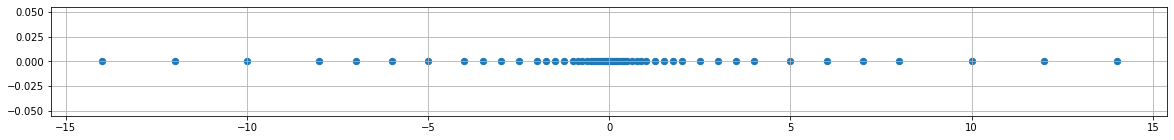

In [6]:
# plot all the achieved values, full range of representation (except infs and nans ofc)
plt.figure(figsize=(20, 2))
plt.scatter(vs, [0]*len(vs), s=40)
plt.grid()

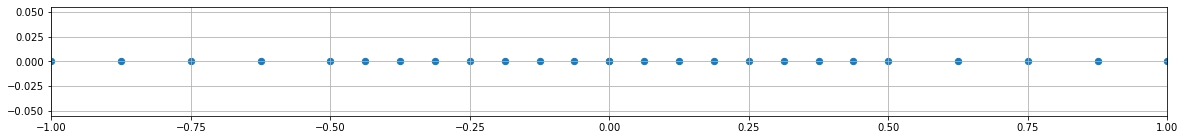

In [7]:
# zoom in on range -1..1, expecting to see uniform spacing near zero via denormalized "gradual underflow"
plt.figure(figsize=(20, 2))
plt.scatter(vs, [0]*len(vs), s=40)
plt.xlim(-1, 1)
plt.grid()

In [8]:
# Now Practice Problem 2.47: 5-bit float with k=2, n=2

chunk = partial(chunk_str3, parts=(1, 2, 2))
for bstr in map(chunk, gen_bits(5)):
    Float.val(bstr, verbose=bstr[0]=='0')
    

bits='0 00 00' e= 0, E=  0, 2^E=1    , f=0/4  , M=0/4  , V=0        Decimal=0.0
bits='0 00 01' e= 0, E=  0, 2^E=1    , f=1/4  , M=1/4  , V=1/4      Decimal=0.25
bits='0 00 10' e= 0, E=  0, 2^E=1    , f=2/4  , M=2/4  , V=1/2      Decimal=0.5
bits='0 00 11' e= 0, E=  0, 2^E=1    , f=3/4  , M=3/4  , V=3/4      Decimal=0.75
bits='0 01 00' e= 1, E=  0, 2^E=1    , f=0/4  , M=4/4  , V=1        Decimal=1.0
bits='0 01 01' e= 1, E=  0, 2^E=1    , f=1/4  , M=5/4  , V=5/4      Decimal=1.25
bits='0 01 10' e= 1, E=  0, 2^E=1    , f=2/4  , M=6/4  , V=3/2      Decimal=1.5
bits='0 01 11' e= 1, E=  0, 2^E=1    , f=3/4  , M=7/4  , V=7/4      Decimal=1.75
bits='0 10 00' e= 2, E=  1, 2^E=2    , f=0/4  , M=4/4  , V=2        Decimal=2.0
bits='0 10 01' e= 2, E=  1, 2^E=2    , f=1/4  , M=5/4  , V=5/2      Decimal=2.5
bits='0 10 10' e= 2, E=  1, 2^E=2    , f=2/4  , M=6/4  , V=3        Decimal=3.0
bits='0 10 11' e= 2, E=  1, 2^E=2    , f=3/4  , M=7/4  , V=7/2      Decimal=3.5
bits='0 11 00' +Infinity
bits='0 11 

In [9]:
# fp32 example given in the book, verify it gives the integer 12,345
book_bits = '0 10001100 10000001110010000000000'
V = Float.val(book_bits)
print(V)
assert V == 12345.0

bits='0 10001100 10000001110010000000000' e=140, E= 13, 2^E=8192 , f=4252672/8388608, M=12641280/8388608, V=12345    Decimal=12345.0
12345.0


In [10]:
# now, as suggested in the book, let's go backwards: take the integer 12,345 and get the fp32 bit pattern

def bits(n: int):
    bits = []
    while n:
        bits.append(n % 2)
        n = n // 2
    return ''.join(map(str, bits[::-1]))

num = 12345
bitstr = bits(num) # 11000000111001
nshift = len(bitstr) - 1 # number of times we have to shift to normalize the number into scientific notation
frac_bits = bitstr[1:] + '0'*(23 - nshift) # drop the leading 1, and pad to 23 bits of mantissa in fp32
sign_bits = '0' if num >= 0 else '1'
ebitstr = bits(127 + nshift) # 127 is the fp32 bias. since we have 8 exp bits, we have 2**(8-1)-1 = 127
exp_bits = '0' * (8 - len(ebitstr)) + ebitstr # encode the exponent, with padding of zeros as needed in front
bits = ' '.join((sign_bits, exp_bits, frac_bits))
print(bits)
assert bits == book_bits

0 10001100 10000001110010000000000


In [11]:
# finally let's also check that Python / struct agree
import struct

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

py_bits = chunk_str3(binary(12345), (1, 8, 23))
print(py_bits)
assert py_bits == book_bits

0 10001100 10000001110010000000000
